In [1]:
################################################################################
# IMPORTS
################################################################################
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42


# Specify each path

In [2]:
################################################################################
# PATHS
################################################################################
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'


# Set number of classes

In [3]:
NUM_CLASSES = 10

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 43)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED
)

# Model building

In [7]:
################################################################################
# MODEL BUILDING
################################################################################

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(42,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 1180 (4.61 KB)
Trainable params: 1180 (4.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
################################################################################
# CALLBACKS
################################################################################
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path,
    verbose=1,
    save_weights_only=False
)

es_callback = tf.keras.callbacks.EarlyStopping(
    patience=20,
    verbose=1,
    restore_best_weights=True
)


In [10]:
################################################################################
# MODEL COMPILATION
################################################################################
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Model training

In [11]:
################################################################################
# MODEL TRAINING
################################################################################
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)


Epoch 1/1000
 1/27 [>.............................] - ETA: 3s - loss: 2.3995 - accuracy: 0.0859
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
27/27 [==============================] - 0s 3ms/step - loss: 2.2475 - accuracy: 0.1598 - val_loss: 2.0944 - val_accuracy: 0.2153
Epoch 2/1000
 1/27 [>.............................] - ETA: 0s - loss: 2.1880 - accuracy: 0.2031
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
27/27 [==============================] - 0s 989us/step - loss: 2.0564 - accuracy: 0.2533 - val_loss: 1.8915 - val_accuracy: 0.2456
Epoch 3/1000
 1/27 [>.............................] - ETA: 0s - loss: 1.8945 - accuracy: 0.3750
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
27/27 [==============================] - 0s 1ms/step - loss: 1.9194 - accuracy: 0.2921 - val_loss: 1.7607 - val_accuracy: 0.3470
Epoch 4/1000
 1/27 [>.............................] - ETA: 0s - loss: 1.9456 - accuracy: 0.2

In [12]:
################################################################################
# EVALUATION
################################################################################
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)


9/9 [==============================] - 0s 405us/step - loss: 0.2127 - accuracy: 0.9733
Validation Loss: 0.2126934826374054
Validation Accuracy: 0.9733096361160278


In [13]:
################################################################################
# LOAD SAVED MODEL
################################################################################
model = tf.keras.models.load_model(model_save_path, compile=False)


In [14]:
################################################################################
# INFERENCE TEST
################################################################################
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print("Predicted Class:", np.argmax(np.squeeze(predict_result)))


1/1 [==============================] - 0s 33ms/step
[9.92598057e-01 9.08553120e-05 1.26464898e-03 1.42697536e-04
 2.80602517e-14 1.00943585e-11 2.36702348e-07 5.90348477e-03
 6.30737962e-11 8.91933361e-10]
Predicted Class: 0


# Confusion matrix

36/36 [==============================] - 0s 239us/step


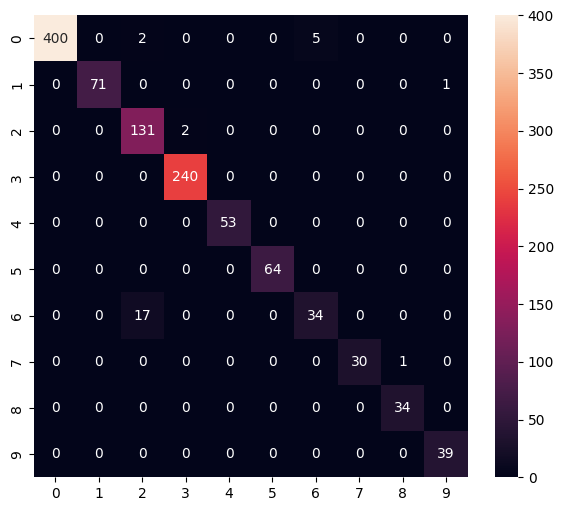

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       407
           1       1.00      0.99      0.99        72
           2       0.87      0.98      0.93       133
           3       0.99      1.00      1.00       240
           4       1.00      1.00      1.00        53
           5       1.00      1.00      1.00        64
           6       0.87      0.67      0.76        51
           7       1.00      0.97      0.98        31
           8       0.97      1.00      0.99        34
           9       0.97      1.00      0.99        39

    accuracy                           0.98      1124
   macro avg       0.97      0.96      0.96      1124
weighted avg       0.98      0.98      0.97      1124



In [15]:
################################################################################
# CONFUSION MATRIX
################################################################################
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(labels), 0)
    plt.show()
    
    if report:
        print("Classification Report")
        print(classification_report(y_true, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)


# Convert to model for Tensorflow-Lite

In [16]:
################################################################################
# SAVE INFERENCE MODEL
################################################################################
h5_save_path = 'keypoint_classifier.h5'

# Save the model for inference (without optimizer)
model.save(h5_save_path, include_optimizer=False)

# Load the model for inference
model = tf.keras.models.load_model(h5_save_path, compile=False)


/Users/mohamedabdullrahma/Desktop/ECS 170/ECS-170-Group-Project/mp_env/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
################################################################################
# TFLITE CONVERSION (QUANTIZED)
################################################################################
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = False 

tflite_quantized_model = converter.convert()

with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

print("Saved:", tflite_save_path)


INFO:tensorflow:Assets written to: /var/folders/n_/vp93498x3cn_0ykwxdwxmpjr0000gn/T/tmpujaelzhv/assets


INFO:tensorflow:Assets written to: /var/folders/n_/vp93498x3cn_0ykwxdwxmpjr0000gn/T/tmpujaelzhv/assets
2025-12-05 20:56:23.424197: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-12-05 20:56:23.424255: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-12-05 20:56:23.438237: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-12-05 20:56:23.438299: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


Saved: model/keypoint_classifier/keypoint_classifier.tflite


# Inference test

In [18]:
################################################################################
# LOAD TFLITE MODEL
################################################################################
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 48 μs, sys: 25 μs, total: 73 μs
Wall time: 67 μs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.9259806e-01 9.0855574e-05 1.2646503e-03 1.4269765e-04 2.8060309e-14
 1.0094397e-11 2.3670189e-07 5.9034876e-03 6.3073921e-11 8.9193514e-10]
0
